In [17]:
import sys
base_path_diff_hef = './src/'
sys.path.insert(0,base_path_diff_hef)

In [13]:
import random
import numpy as np
import torch

random_seed  = 42 
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [18]:
from data_generation.SE2.range_simulator import generate_bounded_se2_dataset,SE2Group
import numpy as np
import torch
from distributions.SE2.se2_distribution import SE2, SE2Gaussian
from distributions.SE2.SE2_torch import SE2_FFT
from utils.sampler import se2_grid_samples_torch


In [20]:
device = torch.device("cpu")

In [7]:
num_trajectories = 10
trajectory_length = 80
grid_size = [50,50,32]
step_motion = [0.01, 0.00, math.pi / 40]
motion_cov = [0.001, 0.001, 0.001]
measurement_cov = 0.0001
# poses = torch.zeros((num_trajectories, trajectory_length, 3))  # Example tensor
batch_size = 1
validation_split = 0.2
test_split = 0.1



In [19]:

np.random.seed(random_seed)
_, _, test_loader = generate_bounded_se2_dataset(
    num_trajectories=num_trajectories,
    trajectory_length=trajectory_length,
    step_motion=SE2Group(step_motion[0], step_motion[1], step_motion[2]),
    motion_noise=np.sqrt(np.array(motion_cov)),
    measurement_noise=np.sqrt(measurement_cov),
    samples=poses.cpu().numpy(),
    batch_size=batch_size,
    validation_split=validation_split,
    test_split=test_split,

    start_pose=SE2Group(0.0, -0.15, 0)

)

NameError: name 'poses' is not defined

In [94]:
# Get the first batch from the test_loader
first_batch = next(iter(test_loader))


In [95]:
inputs, measurements, measurement_energy, control, beacon_idx = first_batch

In [21]:
torch_fft = SE2_FFT(spatial_grid_size=grid_size,
                interpolation_method='spline',
                spline_order=1,
                oversampling_factor=1, 
                device=device)
poses, X, Y, T = se2_grid_samples_torch(batch_size, grid_size)



In [26]:
mu_1 = torch.tensor([0.1, -0.1, 0.034])

In [28]:
motion_model = SE2Gaussian(mu_1.unsqueeze(0), torch.diag(torch.tensor(motion_cov)).to(torch.float64).to(device), samples=poses, fft=torch_fft)
motion_model.normalize()

In [24]:
import matplotlib.pyplot as plt

def visualize_se2_distribution(motion_model, X, Y, T):
    """
    Visualizes the SE2 distribution by marginalizing over theta, normalizing it, and plotting it.

    Parameters:
    - motion_model: SE2Gaussian object representing the motion model.
    - X, Y, T: Torch tensors representing the spatial grid.

    Returns:
    - None
    """
    if isinstance(motion_model.prob, torch.Tensor):
        # Marginalize over theta by summing along the theta axis
        marginal_distribution = torch.trapz(motion_model.prob.real[0], x=T, dim=2).cpu().numpy()
        X_ = X[:,:, 0].cpu().numpy()
        Y_ = Y[:,:, 0].cpu().numpy()
    elif isinstance(motion_model.prob, np.ndarray):
        # Marginalize over theta by summing along the theta axis
        marginal_distribution = np.trapz(motion_model.prob.real, x=T, axis=2)
        X_ = X[:,:, 0]
        Y_ = Y[:,:, 0]

    # Normalize the marginal distribution
    marginal_distribution_norm = (marginal_distribution - marginal_distribution.min()) / (marginal_distribution.max() - marginal_distribution.min())

    # Convert to numpy for plotting
    # marginal_distribution_norm_np =  marginal_distribution_norm.cpu().numpy()

    # Plot the marginal distribution
    plt.figure(figsize=(8, 6))
    # plt.contourf(X_,Y_, marginal_distribution_norm, levels=50, cmap='viridis')
    plt.pcolormesh(X_, Y_, marginal_distribution_norm , shading='auto', cmap="viridis")
    plt.colorbar(label='Probability Density')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Marginalized SE2 Distribution')
    plt.show()


In [132]:
motion_model.cov

tensor([[0.0010, 0.0000, 0.0000],
        [0.0000, 0.0010, 0.0000],
        [0.0000, 0.0000, 0.0010]], dtype=torch.float64)

In [107]:
mu_torch

tensor([ 0.0257, -0.0044,  0.0990], dtype=torch.float64)

In [126]:
T_tile = torch.tile(T[0,0].unsqueeze(0).unsqueeze(0),[37,223,1])

In [125]:
motion_model_M.shape

(37, 223, 32)

In [129]:
 fft.r_max

tensor(35.3553, dtype=torch.float64)

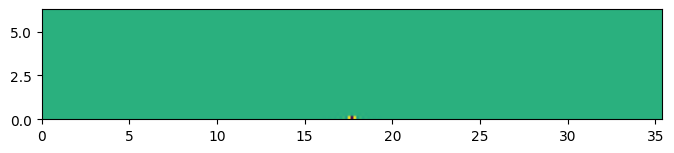

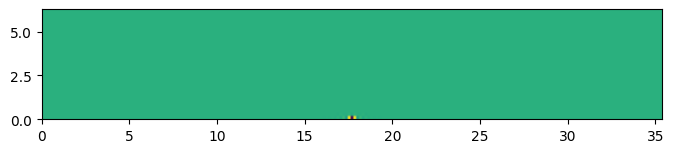

In [ ]:
motion_model_M = motion_model.M.real[0].cpu().numpy()
# Marginalize over theta (last dimension)
f_marginalized = np.trapz(motion_model_M, x=T_tile.numpy(), axis=2)
# Normalize the marginalized result
f_marginalized_normalized = (f_marginalized - f_marginalized.min()) / (f_marginalized.max() - f_marginalized.min())
# Plot the marginalized result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
plt.imshow(f_marginalized_normalized, extent=[0, fft.r_max.item(), 0, 2*math.pi], origin='lower', cmap='viridis')

motion_model_M_np = motion_distribution_np.eta.real
f_marginalized_np = np.trapz(motion_model_M_np, x=T_tile.numpy(), axis=2)
f_marginalized_normalized_np = (f_marginalized_np - f_marginalized_np.min()) / (f_marginalized_np.max() - f_marginalized_np.min())
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
plt.imshow(f_marginalized_normalized_np, extent=[0, fft.r_max.item(), 0, 2*math.pi], origin='lower', cmap='viridis')


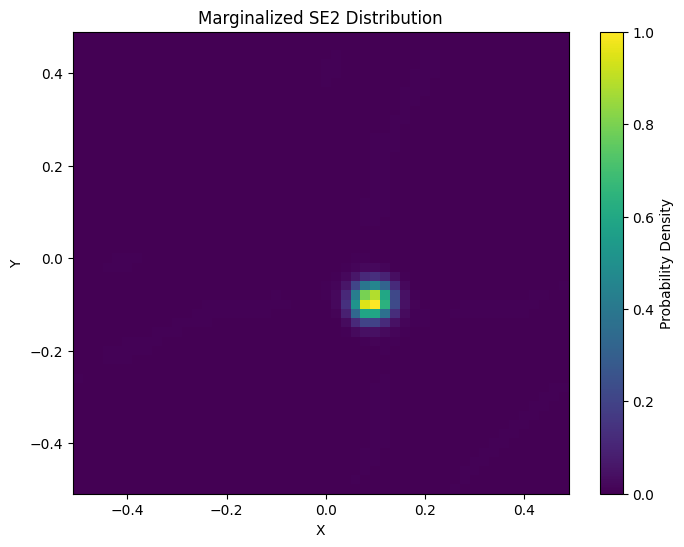

In [29]:

# Example usage
visualize_se2_distribution(motion_model, X, Y, T)

In [8]:
# plotting it in numpy. 
import sys
import math
import numpy as np
base_path = '/home/mila/r/ria.arora/scratch/local/HarmonicExponentialBayesFitler'
sys.path.insert(0,base_path)
from lie_learn.spectral.SE2FFT import SE2_FFT
from src.distributions.se2_distributions import SE2, SE2Gaussian
from src.sampler.se2_sampler import se2_grid_samples
from src.groups.se2_group import SE2Group
from src.simulators.se2_range_simulator import SE2RangeSimulator

random_seed = 42

np_fft = SE2_FFT(
    spatial_grid_size=grid_size,
    interpolation_method="spline",
    spline_order=1,
    oversampling_factor=1,
    )
np_poses, x, y, theta = se2_grid_samples(grid_size)
mu_1 = (0.0, -0.15, 0)
np.random.seed(random_seed)
simulator = SE2RangeSimulator(
    start=SE2Group.from_parameters(*mu_1),
    step=SE2Group.from_parameters(0.01, 0.00, math.pi/ 40.0),
    samples=np_poses,
    fft=np_fft,
    motion_noise=np.sqrt(np.array(motion_cov)),
    measurement_noise=np.sqrt(measurement_cov)
)
# var_prior= [0.1, 0.1, 0.1]
# cov_1 = np.diag(var_prior)
# # Motion and measurement noise
# prior = SE2Gaussian(mu_1, cov_1, samples=np_poses, fft=np_fft)
# prior.normalize()
motion_distribution_np = simulator.motion()

In [16]:
mu_torch = torch.tensor(motion_distribution_np.mu)

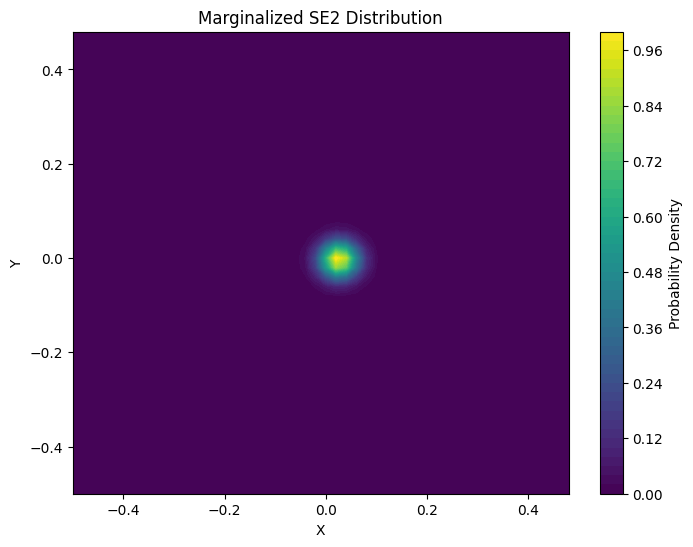

In [15]:
visualize_se2_distribution(motion_distribution_np , x, y, theta)

In [ ]:
def plot_density_heatmap(X, Y, density, title="Density Heatmap", cmap="viridis"):
    """
    Plots a density heatmap using pcolormesh.

    Parameters:
    - X: 2D array-like, x-coordinates of the grid.
    - Y: 2D array-like, y-coordinates of the grid.
    - density: 2D array-like, density values at each grid point.
    - title: str, title of the plot.
    - cmap: str, colormap to use for the heatmap.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(X, Y, density, shading='auto', cmap=cmap)
    plt.colorbar(label='Density')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.show()